In [1]:
from datetime import datetime, date
import pandas as pd
import numpy as np
from scipy import stats
import re, os, nltk, math, csv, json
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from collections import Counter

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
# Google Drive - This will prompt you to click a link to authorize
# (don't execute if running on own machine)
from google.colab import drive, auth, files
from oauth2client.client import GoogleCredentials
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Google Drive - Navigate to directory
# (don't execute if running on own machine)
os.chdir('drive/MyDrive/SocialComQuant22/')
os.listdir('.')

['Data', 'Resources_geolocation', 'Resources_nutrition', 'Untitled0.ipynb']

# NLP for health - case study of Obesity

In public health research, sometimes we want to extract health-relevant signals, and relate them to some health outcome. In this example, we will learn to:
1. Geo-locate tweets to GeoNames locations
2. Apply a food dictionary to extract caloric information
3. Correlate this caloric information to known obesity rates


In [2]:
# Read in the file containing tweet information
tweets = pd.read_csv("Data/tweet_sample.tsv", sep="\t", lineterminator='\n',
                  low_memory=False, quoting=csv.QUOTE_NONE, escapechar=None, header=None, 
                  names=["text", "id", "created_at", "lang", "retweeted_status_id", "retweeted_status_user_id", 
                         "user_id", "user_name", "followers_count", "friends_count", "statuses_count", 
                         "location", "user_created_at", "youtube_ids"],
                  dtype={'id': object, 'retweeted_status_user_id': object, 'retweeted_status_id': object, 'user_id': object})

In [3]:
tweets.shape

(10000, 14)

In [4]:
tweets = tweets.drop_duplicates("id")
tweets.shape

(10000, 14)

In [5]:
tweets.sample(5)

,text,id,created_at,lang,retweeted_status_id,retweeted_status_user_id,user_id,user_name,followers_count,friends_count,statuses_count,location,user_created_at,youtube_ids
6860,ICYMI: Try these fiber-full appetizer recipes ...,1205566682040848384,Fri Dec 13 19:14:30 +0000 2019,en,NaN,NaN,593845461,CtrCommHealth&Prev,434.0,324.0,2135.0,"46 Prince Street, Rochester NY",Tue May 29 14:43:53 +0000 2012,8HAPrrvFF48
4281,What’s Cooking Good Looking?! 👨‍🍳 https://t....,1235224358030897154,Wed Mar 04 15:23:30 +0000 2020,en,1.2352167754296607e+18,53430736.0,626381897,DJBRIT (DJSUSIESKY),1883.0,2166.0,5919.0,None,Wed Jul 04 11:24:47 +0000 2012,dyhvMFFBNyg
9925,"Did I just eat real chicken, 5yrs vegan!!! | T...",1204629433790939137,Wed Dec 11 05:10:12 +0000 2019,en,1.2046287659276247e+18,42851808.0,2256664812,MRX,3210.0,212.0,171290.0,New Jersey,Sat Dec 21 16:17:07 +0000 2013,_ngTKoHBHX8
7417,KETO WEEK 38! | SHOW UP💪 https://t.co/hau5sveG...,1176195281899200512,Mon Sep 23 18:03:02 +0000 2019,en,NaN,NaN,733441806591873024,Julie Hadley,3.0,18.0,34.0,None,Thu May 19 23:38:48 +0000 2016,eRQ7piyjtK4
1486,RT @CartoonCornerWB: Tune in as the Student Do...,1273760439491575808,Thu Jun 18 23:32:08 +0000 2020,en,1.2737513772573983e+18,145861154.0,724369792937779200,Healing Heat Therapy,3261.0,5004.0,48782.0,"Colorado Springs, CO",Sun Apr 24 22:49:51 +0000 2016,UwWR51yFqks


## 1.1 Geo-location

In [6]:
# Pick only tweets with non-empty location field
tweets_withlocs = tweets[tweets.location!="None"]
tweets_withlocs.shape

(6696, 14)

### Define functions to look up GeoNames entities from text

Read in information necessary for geolocation (may take a minute)

In [7]:
# Dictionary mapping (lower-case) strings of locations to ids of places
locdictionary = json.load(open('Resources_geolocation/locdictionary.json'))
# Data frame mapping ids of places to metadata about these places
locationdata = pd.read_csv("Resources_geolocation/countriesdatap.tsv.gz", sep='\t', low_memory=False, index_col="geonameid")

In [8]:
# Stopwords to remove spurious matches
nltk.download('stopwords')
engstopwords = stopwords.words('english')
numbers = {'zero','one','two','three','four','five','six','seven','eight','nine','ten',
           'eleven','twelve','thirteen','fourteen','fifteen','sixteen','seventeen','eighteen',
           'nineteen','twenty','thirty','fourty','fifty','sixty','seventy','eighty','ninety',
           'hundred','thousand','million','billion','zillion'}

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ymejova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Lookup functions ######################################################

# Turn tokens into a sequence of n-grams
def word_ngrams(tokens, ngrams):
    min_n, max_n = 1, ngrams
    if max_n != 1:
        original_tokens = tokens
        tokens = []
        n_original_tokens = len(original_tokens)
        for n in range(min_n, min(max_n + 1, n_original_tokens + 1)):
            for i in range(n_original_tokens - n + 1):
                tokens.append(" ".join(original_tokens[i: i + n]))
    return tokens

# Finds all the longest string matches for a piece of text
tokenizer = RegexpTokenizer(r'\w+')
def find_names(text):
    tokens = word_ngrams(tokenizer.tokenize(text.lower()), 5)
    m = set()
    for token in tokens:
        if token in locdictionary:
            m.add(token)
    # filter out matched places that are substrings of another matched place
    k_list = list(m)
    for i, k in enumerate(k_list):
        for k2 in k_list[:i]:
            if k in k2 and k in m:
                m.remove(k)
        for k2 in k_list[i+1:]:
            if k in k2 and k in m:
                m.remove(k)
    return m

# Finds the best match for the text
# For speed reasons, returns only the geonamesid which can be used to index into locationdata
def find_best_match(text):
    # Try finding all the matches
    mymatches = find_names(text)
    bestmatch = None
    matcharray = []
    matchedids = []
    foundcountry = None
    countrymatches = None
    # Put all the matches in one array
    for foundloc in mymatches:
        matchedids = matchedids + locdictionary[foundloc]
    # If there is more than 1 match, and there is a match to a country, constrain all other matches to that country
    if len(matchedids) > 1:
        matchedlocations = locationdata.loc[matchedids]
        if pd.DataFrame.any(matchedlocations.featurecode=="PCLI"):
            foundcountry = matchedlocations[matchedlocations.featurecode=="PCLI"].iloc[0].countrycode
            countrymatches = matchedlocations[matchedlocations.countrycode==foundcountry]
    # For each word match, find the most populous one
    for foundloc in mymatches:
        # Handle special cases
        if len(foundloc) < 2:
            continue
        if (foundloc in engstopwords) | (foundloc in numbers):
            continue
        if (foundloc=="new york") | (foundloc=="ny") | (foundloc=="ny ny") | (foundloc=="new york ny") | (foundloc=="nyc"):
            matcharray.append(5128581) # city, not state
        if (foundloc=="he his") | (foundloc=="she her") | (foundloc=="he") | (foundloc=="his") | \
        (foundloc=="she") | (foundloc=="her") | (foundloc=="they") | (foundloc=="them") | (foundloc=="they them"):
            continue
        if (foundloc=="none") | (foundloc=="null") | (foundloc=="na") | (foundloc=="nan"):
            continue
        if (foundloc=="secret") | (foundloc=="zone") | (foundloc=="hell") | (foundloc=="landing") | (foundloc=="rainbow") |\
        (foundloc=="south") | (foundloc=="north") | (foundloc=="east") | (foundloc=="west") | \
        (foundloc=="southeast") | (foundloc=="northeast") | (foundloc=="southwest") | (foundloc=="northwest") | \
        (foundloc=="se") | (foundloc=="ne") | (foundloc=="sw") | (foundloc=="nw"):
            continue
        else:
            matchedlocations = locationdata.loc[locdictionary[foundloc],:]
            if foundcountry: # Remove matches that are not in the country we found
                matchedlocations = matchedlocations[matchedlocations.countrycode==foundcountry]
            if matchedlocations.shape[0] > 0:
                foundmatch = matchedlocations.sort_values(by="population",ascending=False).index[0]
                matcharray.append(foundmatch)
    # Among all the matches, find the least populous one
    if len(matcharray) > 0:
        allmatches = locationdata.loc[matcharray]
        bestmatch = allmatches.sort_values(by="population",ascending=True).index[0]
    return bestmatch

### Apply GeoNames tagging to our data

(may take a minutes)

In [10]:
# Find the geonames IDs of best matches
tweets_withlocs["geonameid"] = tweets_withlocs["location"].apply(lambda x: find_best_match(x))

/var/folders/12/9ngr75n132qbdvxgkxdfxpnh0000gn/T/ipykernel_54260/1024083383.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_withlocs["geonameid"] = tweets_withlocs["location"].apply(lambda x: find_best_match(x))


In [11]:
# Number of records that have non-empty matches
tweets_withlocs = tweets_withlocs[~tweets_withlocs["geonameid"].isna()]
tweets_withlocs.shape

(6159, 15)

In [12]:
# Join with the rest of information on the location
interesting_columns = ['geonameid', 'name', 'asciiname', 'latitude', 'longitude',
       'featureclass', 'featurecode', 'countrycode', 'cc2', 'admin1code', 'population', 'timezone']
tweets_withlocs_info = tweets_withlocs.merge(locationdata.reset_index()[interesting_columns], on="geonameid")
tweets_withlocs_info.shape

(6159, 26)

In [13]:
tweets_withlocs_info.sample(5)

,text,id,created_at,lang,retweeted_status_id,retweeted_status_user_id,user_id,user_name,followers_count,friends_count,...,asciiname,latitude,longitude,featureclass,featurecode,countrycode,cc2,admin1code,population,timezone
1044,20 Min Chair Exercises Sitting Down Workout - ...,1164486246212734977,Thu Aug 22 10:35:30 +0000 2019,en,NaN,NaN,922961141650939909,HAZELS-ART,380.0,2025.0,...,England,52.16045,-0.70312,A,ADM1,GB,NaN,ENG,55268067,Europe/London
4980,"Things are looking up with my weightloss, so I...",1267599761898536960,Mon Jun 01 23:31:48 +0000 2020,en,NaN,NaN,1137223008433500160,Jessie Rae 🚵‍♀️,7.0,26.0,...,Nevada,39.25021,-116.75119,A,ADM1,US,NaN,NV,2399532,America/Los_Angeles
1290,#ASPARTAME in #DIET SODA KILLS (AND it makes y...,1268600219790446598,Thu Jun 04 17:47:16 +0000 2020,en,NaN,NaN,22080308,Mary Nash Stoddard,1141.0,1200.0,...,Dallas County,32.76663,-96.77787,A,ADM2,US,NaN,TX,2368139,America/Chicago
535,"Dr. Greger, https://t.co/sHOPIC6usX - Keto Die...",1216691666586873857,Mon Jan 13 12:01:13 +0000 2020,en,NaN,NaN,560326393,Inspiration,6.0,10.0,...,United States,39.76000,-98.50000,A,PCLI,US,NaN,00,327167434,NaN
4364,When Rappers Go #Vegan 🔥🔥🔥https://t.co/gtXU3HRR1q,1177063730049429504,Thu Sep 26 03:33:56 +0000 2019,en,NaN,NaN,2164861759,Donaldknottz Ⓥ,1185.0,1941.0,...,Massachusetts,42.36565,-71.10832,A,ADM1,US,NaN,MA,6433422,America/New_York


In [14]:
# How good are the matches? Let's examine a sample
tweets_withlocs_info[['location', 'name', 'asciiname', 'admin1code', 'countrycode', 'latitude', 'longitude']].sample(10)

,location,name,asciiname,admin1code,countrycode,latitude,longitude
4204,"Indianapolis, IN US",Indianapolis,Indianapolis,IN,US,39.76838,-86.15804
5533,NJ • VA • CHI,Chittoor,Chittoor,2.0,IN,13.41667,79.00000
2507,"Washington, USA",Washington,Washington,WA,US,47.50012,-120.50147
4573,"Belluno, Veneto",Provincia di Belluno,Provincia di Belluno,20.0,IT,46.25000,12.13333
2521,"St Louis, Missouri",St. Louis,St. Louis,MO,US,38.63162,-90.24925
4866,"Canton, Ohio USA",Canton,Canton,OH,US,40.79895,-81.37845
5466,"Dix Hills, NY",Dix Hills,Dix Hills,NY,US,40.80482,-73.33623
5340,"Dublin City, Ireland",Dublin,Dublin,L,IE,53.33306,-6.24889
3055,"Ljubljana, Slovenia",Mestna Občina Ljubljana,Mestna Obcina Ljubljana,61,SI,46.05918,14.50916
5032,"Croydon, England",Croydon,Croydon,ENG,GB,51.37664,-0.10574


In [15]:
# Select only the tweets within US 
tweets_withlocs_info_US = tweets_withlocs_info[tweets_withlocs_info.countrycode=="US"]
tweets_withlocs_info_US.shape

(3256, 26)

In [16]:
# How much data do we have for each state?
tweets_withlocs_info_US.admin1code.value_counts()

00    457
CA    385
TX    277
NY    230
WA    180
FL    169
IL    163
PA     84
MD     80
NJ     78
NC     77
MI     77
OH     74
GA     71
MO     66
CO     52
OR     51
AZ     51
NE     46
MA     45
AK     45
VA     39
TN     33
NV     29
KS     29
IN     27
MN     26
SC     24
LA     21
WI     20
CT     19
AR     19
MS     19
AL     18
NM     18
DC     14
KY     13
ID     13
UT     12
OK     12
MT     11
IA     10
ND     10
SD      9
HI      9
VT      6
ME      5
DE      4
WY      4
NH      3
RI      3
WV      2
Name: admin1code, dtype: int64

In [17]:
# What are the most popular locations?
tweets_withlocs_info_US.asciiname.value_counts()

United States    457
New York City    158
Chicago          118
Seattle          118
California        74
                ... 
Marcus Hook        1
Huntington         1
Shallotte          1
Redmond            1
Strongsville       1
Name: asciiname, Length: 626, dtype: int64

In [18]:
# Another way to geolocate, using a service
from geopy.geocoders import Nominatim
from pprint import pprint
app = Nominatim(user_agent="tutorial")
location = app.geocode("Iowa City, Iowa").raw
pprint(location)

{'boundingbox': ['41.5985476', '41.696634', '-91.6157854', '-91.4630645'],
 'class': 'boundary',
 'display_name': 'Iowa City, Johnson County, Iowa, United States',
 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons/poi_boundary_administrative.p.20.png',
 'importance': 0.8643105953463947,
 'lat': '41.6612561',
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. '
            'https://osm.org/copyright',
 'lon': '-91.5299106',
 'osm_id': 128462,
 'osm_type': 'relation',
 'place_id': 297910113,
 'type': 'administrative'}


## 1.2 Linking text to nutritional information

Read in the nutrition / food list

In [19]:
# Read in a large dataset of food-related tweets with their geo-location at state level
food_tweets = pd.read_csv("Resources_nutrition/food_tweets.txt", sep="\t")
food_tweets.columns = ["text","state"]
food_tweets.shape

(909604, 2)

In [20]:
food_tweets.sample(5)

,text,state
518203,@Bradley_2012_ naw we gotta put meat on the ta...,AL
530714,So many good things to eat in here (@ Iavarone...,NY
155331,I've now been to Starbucks three times in less...,IL
595085,So glad the Devereux's like food as much as I ...,NY
434111,I could have gone to community college and exp...,VA


In [21]:
# Read in a list of popular foods with caloric info per 100 grams
caloriedata = pd.read_csv("Resources_nutrition/top_500_foods_calories.txt", sep="\t")
caloriedata.columns = ["food", "energy"]
caloriedata = caloriedata.drop_duplicates("food")
caloriedata.shape

(474, 2)

In [22]:
caloriedata.sample(10)

,food,energy
253,bologna,247.000000
271,quail,107.100000
263,chicken liver,196.880000
391,gourd,91.235294
97,salsa,31.920000
425,apricots,48.000000
393,durian,239.250000
438,chestnuts,82.400000
127,grapes,67.000000
205,cabbages,20.920000


### Define functions to find longest foods in text

In [23]:
# Remove special characters from food names
caloriedata.food = caloriedata.food.apply(lambda x: re.sub(r'\W+', ' ', x))
caloriedata = caloriedata.drop_duplicates("food")
caloriedata.shape

(474, 2)

In [24]:
# Create a dictionary of foods
foodhash = {k:v for k, v in zip(caloriedata.food, [1] * len(caloriedata.food))}

In [25]:
# Regular expression for removing URLs
re_url = re.compile(r'https?:\/\/.*[\r\n]*', flags=re.U)
# Tokenizer for breaking text into words
tokenizer = RegexpTokenizer(r'\w+')

def findfoods (x):
  # Remove URLs
  x = re_url.sub('', x)
  # Tokenize text into words
  words = tokenizer.tokenize(x.lower())

  # Match all substrings with the list of foods
  l = len(words)
  matches = []
  for n in range(l):
    for i in range(n+1):
      phrase = " ".join(words[i:l-n+i])
      if phrase in foodhash:
        matches.append(phrase)

  # Remove duplicates
  matches = list(dict.fromkeys(matches))
  # Sort by length
  matches = sorted(matches, key=len)
  # Throw away matches that are substrings of other matches
  umatches = []
  for i in range(len(matches)):
    if not any(matches[i] in x for x in matches[(i+1):]):
      umatches.append(matches[i])

  return umatches

In [26]:
x = "I love my chocolate peanut butter cookie in the morning"
findfoods(x)

['cookie', 'chocolate', 'peanut butter']

### Apply food discovery to our data

In [27]:
# Run food discovery on the text of our data - takes about 3 minutes
food_tweets["food"] = food_tweets.text.apply(lambda x: findfoods(x))

In [28]:
# How many tweets have matches?
food_tweets = food_tweets[food_tweets.food.str.len()>0]
food_tweets.shape

(141482, 3)

In [29]:
# Make a mapping between foods and tweets
tweets_food_list = food_tweets.reset_index()[["index","food"]].explode("food").drop_duplicates("index")
tweets_food_list

,index,food
0,13,turnips
1,17,fries
2,23,corn
3,30,cheese
4,34,chili
...,...,...
141477,909579,snack
141478,909585,sausage
141479,909593,biscuits
141480,909594,fruit


In [30]:
# Merge with list of calories
tweets_food_list_calories = tweets_food_list.merge(caloriedata, on="food")
tweets_food_list_calories.shape

(141482, 3)

In [31]:
# Calculate average caloric value per tweet
tweet_calorie_average = tweets_food_list_calories.groupby("index").energy.mean().reset_index()
tweet_calorie_average

,index,energy
0,13,32.24
1,17,312.00
2,23,168.72
3,30,402.00
4,34,156.76
...,...,...
141477,909579,132.88
141478,909585,346.00
141479,909593,353.00
141480,909594,52.00


In [32]:
# Merge with original document list
food_tweets_energy = food_tweets.reset_index().merge(tweet_calorie_average, on="index")
food_tweets_energy.head()

,index,text,state,food,energy
0,13,Turnips smell like chocolate chip cookies when...,NY,"[turnips, cookies, chocolate]",32.24
1,17,@WayLynnTaylor ya I'm eating French fries and ...,MA,"[fries, pickles]",312.00
2,23,Luckiest girl in the world! David is cooking ...,FL,"[corn, steak, broccoli]",168.72
3,30,What's better then laying in bed watching movi...,IN,[cheese],402.00
4,34,Eating some yummy chili on this cold rainy eve,OH,[chili],156.76


In [33]:
# Aggregate by state and calculate the average caloric value
tweet_calorie_average = food_tweets_energy.groupby("state").energy.mean().reset_index()
tweet_calorie_average.sort_values(by="energy")

,state,energy
34,None,191.622561
10,HI,192.730679
0,AK,197.826718
33,NY,199.192885
47,WA,199.401039
50,WY,200.093617
6,CT,201.323906
40,SC,201.850475
8,FL,201.871676
5,CO,202.286818


## 1.3 Comparing to health statistics

In [34]:
# Read in known statistics on obesity
stateobesity = pd.read_csv("Resources_nutrition/state_obesity_rate_2022.csv")
stateobesity

,state_long,state,obesity,population
0,Alabama,AL,36.1,4949697
1,Alaska,AK,30.5,720763
2,Arizona,AZ,31.4,7640796
3,Arkansas,AR,37.4,3042017
4,California,CA,26.3,39664128
5,Colorado,CO,23.8,5961083
6,Connecticut,CT,29.1,3546588
7,Delaware,DE,34.4,998619
8,Florida,FL,27.0,22177997
9,Georgia,GA,33.1,10936299


In [35]:
# Merge the information about the tweet calories and state obesity rate
stateobesity_tweetcalories = stateobesity.merge(tweet_calorie_average, on="state")
stateobesity_tweetcalories.sort_values(by="energy")

,state_long,state,obesity,population,energy
10,Hawaii,HI,25.0,1401709,192.730679
1,Alaska,AK,30.5,720763,197.826718
31,New York,NY,27.1,19223191,199.192885
46,Washington,WA,28.3,7887965,199.401039
49,Wyoming,WY,29.7,582233,200.093617
6,Connecticut,CT,29.1,3546588,201.323906
39,South Carolina,SC,35.4,5342388,201.850475
8,Florida,FL,27.0,22177997,201.871676
5,Colorado,CO,23.8,5961083,202.286818
25,Montana,MT,28.3,1093117,202.569845


In [36]:
# Compute Pearson correlation using scipy (gives correlation & p-value)
stats.pearsonr(stateobesity_tweetcalories.obesity, stateobesity_tweetcalories.energy)

(0.4199245892234854, 0.0023980906034028926)

### Plotting the comparison

In [37]:
# Compute a linear regression line
from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()
X = stateobesity_tweetcalories.obesity.values.reshape(-1, 1)
Y = stateobesity_tweetcalories.energy.values.reshape(-1, 1)
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

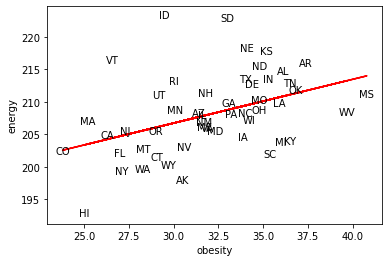

In [38]:
# Plot the obesity vs energy and plot the line
stateobesity_tweetcalories.plot.scatter(x = "obesity", y = "energy", c = "white")
for x,y,l in zip(stateobesity_tweetcalories.obesity, stateobesity_tweetcalories.energy, stateobesity_tweetcalories.state):
    plt.annotate(l, (x,y), textcoords="offset points", xytext=(0,-2), ha='center') 
plt.plot(X, Y_pred, color='red')
plt.show()